## Datos anteriores

In [14]:
import pandas as pd
import warnings
import matplotlib.ticker as ticker

warnings.filterwarnings("ignore")

url_clientes = "https://gist.githubusercontent.com/ahcamachod/d08898e1cc84c7271856e78d9558ca3d/raw/2f7e1fa53711efe6433a5c5ec79948f600591cb9/clientes_zoop.csv"
url_ventas = "https://gist.githubusercontent.com/ahcamachod/966d7162a3c3a2769b8770b35abf1bcc/raw/d79941b3fa46a450f3611589abd8663399c1277b/ventas_zoop.csv"
url_zoop_pay = "https://gist.githubusercontent.com/ahcamachod/ce728231a836a973c0df94a9f03ed871/raw/8db6da43d7cd94fcab937208067d0fceb521b78c/zoop_pay.csv"

clientes = pd.read_csv(url_clientes)
ventas = pd.read_csv(url_ventas)
ventas["fecha"] = pd.to_datetime(ventas["fecha"], format="%Y-%m-%d")
ventas["horario"] = pd.to_datetime(ventas["horario"], format="%H:%M").dt.time

df = pd.merge(ventas, clientes, on="ID_compra", how="inner")
# Reorganizar las columnas en el orden deseado
columnas_ordenadas = [
    "ID_compra",
    "fecha",
    "horario",
    "categoria",
    "precio_unitario",
    "cantidad",
    "envio",
    "metodo_pago",
    "ID_cliente",
    "edad",
    "sexo_biologico",
    "ciudad",
    "estado",
    "region",
    "cashback",
    "nota",
]

# Aplicar el orden de las columnas
df = df[columnas_ordenadas]

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Crear la tabla resumen
metodos_de_pago = df["metodo_pago"].value_counts().reset_index()
metodos_de_pago.columns = ["metodo_pago", "cantidad"]

# 1. Crear una columna de facturación total por compra
df["facturacion"] = df["precio_unitario"] * df["cantidad"] + df["envio"]

# 2. Agrupar por categoría y sumar la facturación
facturacion_categoria = df.groupby("categoria")["facturacion"].sum().sort_values()

# Asegurarse de que la columna 'fecha' es datetime
df["fecha"] = pd.to_datetime(df["fecha"])

# Crear columna con el mes como texto completo
df["mes_nombre"] = df["fecha"].dt.strftime("%B")  # e.g., 'January', 'February', etc.

# Crear columna con el número del mes para ordenar correctamente
df["mes_numero"] = df["fecha"].dt.month

# Calcular la facturación mensual
ventas_mensuales = (
    df.groupby(["mes_numero", "mes_nombre"])["facturacion"].sum().reset_index()
)

# Ordenar por número de mes
ventas_mensuales = ventas_mensuales.sort_values("mes_numero")

# Diccionario de traducción de meses
meses = {
    "January": "Ene",
    "February": "Feb",
    "March": "Mar",
    "April": "Abr",
    "May": "May",
    "June": "Jun",
    "July": "Jul",
    "August": "Ago",
    "September": "Sep",
    "October": "Oct",
    "November": "Nov",
    "December": "Dic",
}

# Aplicar traducción
ventas_mensuales["mes"] = ventas_mensuales["mes_nombre"].map(meses)

# 2. Crear columna de trimestre (formato 'T1', 'T2', etc.)
df["trimestre"] = df["fecha"].dt.to_period("Q").astype(str).str.replace("2023Q", "T")

# 3. Agrupar por trimestre y método de pago, sumando facturación
ventas_trimestre = (
    df.groupby(["trimestre", "metodo_pago"])["facturacion"].sum().unstack(fill_value=0)
)

# Filtrar solo las 3 categorías deseadas
categorias_interes = ["Papelería y oficina", "Libros", "Alimentos y bebidas"]
df_filtrado = df[df["categoria"].isin(categorias_interes)]

# Agrupar por trimestre y categoría, sumando la facturación
ventas_categoria = (
    df_filtrado.groupby(["trimestre", "categoria"])["facturacion"]
    .sum()
    .unstack(fill_value=0)
)

# Adicionamos los colores al proyecto
ROJO_1, ROJO_2, ROJO_3 = "#e23155", "#cc2c4e", "#b32742"
AZUL_1, AZUL_2, AZUL_3 = "#203f75", "#1c3867", "#19325b"
BLANCO, GRIS_1, GRIS_2, GRIS_3, GRIS_4, GRIS_5 = (
    "#ffffff",
    "#ebebeb",
    "#d9d9d9",
    "#cccccc",
    "#555655",
    "#231f20",
)
AQUA_1, AQUA_2, AQUA_3 = "#addcd4", "#9fccc5", "#96bfb9"

# Generando funciones para los gráficos

## Gráfico 1: Métodos de pago más utilizados en 2023

```python
metodos_de_pago = df["metodo_pago"].value_counts().reset_index()
metodos_de_pago.columns = ["metodo_pago", "cantidad"]

# 2. Calcular porcentaje
top_2 = metodos_de_pago["cantidad"][:2].sum()
total = metodos_de_pago["cantidad"].sum()
porcentaje = round((top_2 / total) * 100, 1)

# 3. Visualización
plt.figure(figsize=(10, 6), facecolor=GRIS_1)
ax = sns.barplot(data=metodos_de_pago, x="metodo_pago", y="cantidad", color=ROJO_1)

# Personalización del gráfico
ax.set_facecolor(GRIS_1)
ax.set_title("Métodos de pago más utilizados en 2023", fontsize=18, color=GRIS_5)

# Eje X
ax.set_xlabel("Método de Pago", fontsize=12, color=AZUL_1)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, color=AZUL_1)

# Eje Y eliminado
ax.set_ylabel(None)
ax.set_yticks([])

# Quitar bordes
for spine in ["left", "top", "right"]:
    ax.spines[spine].set_visible(False)

# Añadir cantidades sobre las barras
for i, row in metodos_de_pago.iterrows():
    ax.text(
        i,
        row["cantidad"] + max(metodos_de_pago["cantidad"]) * 0.01,
        int(row["cantidad"]),
        ha="center",
        fontsize=12,
        color=AZUL_1,
    )

# Añadir texto explicativo en el gráfico
texto = (
    f"$\\bf{porcentaje}$% de los clientes utilizan Tarjeta de Crédito o Transferencia \n"
    "para el pago. Sería interesante considerar asociaciones con \n"
    "bancos para la creación de un Zoop Pay con el fin de fidelizar \n"
    "a nuestra clientela."
)

ax.text(1.5, 2500, texto, fontsize=10, color=AZUL_3)

# plt.tight_layout()
plt.show()
```

In [15]:
def metodo_pago():
    metodos_de_pago = df["metodo_pago"].value_counts().reset_index()
    metodos_de_pago.columns = ["metodo_pago", "cantidad"]

    # 2. Calcular porcentaje
    top_2 = metodos_de_pago["cantidad"][:2].sum()
    total = metodos_de_pago["cantidad"].sum()
    porcentaje = round((top_2 / total) * 100, 1)

    # 3. Visualización
    plt.figure(figsize=(10, 6), facecolor=GRIS_1)
    ax = sns.barplot(data=metodos_de_pago, x="metodo_pago", y="cantidad", color=ROJO_1)

    # Personalización del gráfico
    ax.set_facecolor(GRIS_1)
    ax.set_title("Métodos de pago más utilizados en 2023", fontsize=18, color=GRIS_5)

    # Eje X
    ax.set_xlabel("Método de Pago", fontsize=12, color=AZUL_1)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, color=AZUL_1)

    # Eje Y eliminado
    ax.set_ylabel(None)
    ax.set_yticks([])

    # Quitar bordes
    for spine in ["left", "top", "right"]:
        ax.spines[spine].set_visible(False)

    # Añadir cantidades sobre las barras
    for i, row in metodos_de_pago.iterrows():
        ax.text(
            i,
            row["cantidad"] + max(metodos_de_pago["cantidad"]) * 0.01,
            int(row["cantidad"]),
            ha="center",
            fontsize=12,
            color=AZUL_1,
        )

    # Añadir texto explicativo en el gráfico
    texto = (
        f"$\\bf{porcentaje}$% de los clientes utilizan Tarjeta de Crédito o Transferencia \n"
        "para el pago. Sería interesante considerar asociaciones con \n"
        "bancos para la creación de un Zoop Pay con el fin de fidelizar \n"
        "a nuestra clientela."
    )

    ax.text(1.5, 2500, texto, fontsize=10, color=AZUL_3)

    return plt

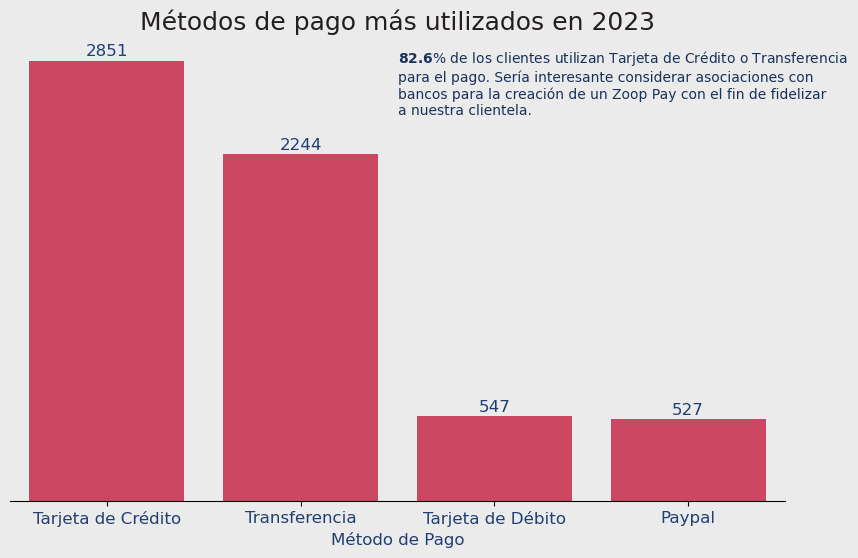

In [16]:
metodo_pago().show()

## Gráfico 2: Ventas totales mensuales del 2023

```python
# Preparar los datos
df["mes"] = df["fecha"].dt.strftime("%B")
ventas_mensuales = df.groupby("mes")["facturacion"].sum().reindex(meses.keys())
ventas_mensuales.index = [meses[m] for m in ventas_mensuales.index]

# Crear figura y eje
fig, ax = plt.subplots(figsize=(12, 6), facecolor=GRIS_1)
ax.set_facecolor(GRIS_1)

# Graficar línea
ax.plot(
    ventas_mensuales.index,
    ventas_mensuales.values,
    marker="o",
    color=AZUL_1,
    linewidth=2,
)

# Título
ax.set_title("Ventas totales mensuales en 2023", fontsize=18, color=GRIS_5)

# Ejes
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(axis="x", labelsize=12, labelcolor=AZUL_1)
ax.tick_params(axis="y", labelsize=12, labelcolor=AZUL_1)


# Formato del eje Y
def millones_mxn(x, _):
    return f"MXN$ {x/1e6:.2f} M"


ax.yaxis.set_major_formatter(ticker.FuncFormatter(millones_mxn))

# Quitar bordes derecho y superior
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Encontrar los 4 puntos más altos
top_ventas = ventas_mensuales.sort_values(ascending=False).head(4)
for i, (mes, valor) in enumerate(top_ventas.items(), 1):
    idx = list(ventas_mensuales.index).index(mes)

    # Dibujar círculo con scatter
    ax.scatter(idx, valor, s=200, facecolors="none", edgecolors=ROJO_1, linewidth=2)

    # Agregar número a la izquierda
    ax.text(idx - 0.6, valor, str(i), fontsize=12, color=ROJO_1, va="center")

# plt.tight_layout()
plt.show()

```

In [ ]:
def ventas_mensuales():
    # Preparar los datos
    df["mes"] = df["fecha"].dt.strftime("%B")
    ventas_mensuales = df.groupby("mes")["facturacion"].sum().reindex(meses.keys())
    ventas_mensuales.index = [meses[m] for m in ventas_mensuales.index]

    # Crear figura y eje
    fig, ax = plt.subplots(figsize=(12, 6), facecolor=GRIS_1)
    ax.set_facecolor(GRIS_1)

    # Graficar línea
    ax.plot(
        ventas_mensuales.index,
        ventas_mensuales.values,
        marker="o",
        color=AZUL_1,
        linewidth=2,
    )

    # Título
    ax.set_title("Ventas totales mensuales en 2023", fontsize=18, color=GRIS_5)

    # Ejes
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis="x", labelsize=12, labelcolor=AZUL_1)
    ax.tick_params(axis="y", labelsize=12, labelcolor=AZUL_1)

    # Formato del eje Y
    def millones_mxn(x, _):
        return f"MXN$ {x/1e6:.2f} M"

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(millones_mxn))

    # Quitar bordes derecho y superior
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Encontrar los 4 puntos más altos
    top_ventas = ventas_mensuales.sort_values(ascending=False).head(4)
    for i, (mes, valor) in enumerate(top_ventas.items(), 1):
        idx = list(ventas_mensuales.index).index(mes)

        # Dibujar círculo con scatter
        ax.scatter(idx, valor, s=200, facecolors="none", edgecolors=ROJO_1, linewidth=2)

        # Agregar número a la izquierda
        ax.text(idx - 0.6, valor, str(i), fontsize=12, color=ROJO_1, va="center")

    # plt.tight_layout()
    return plt

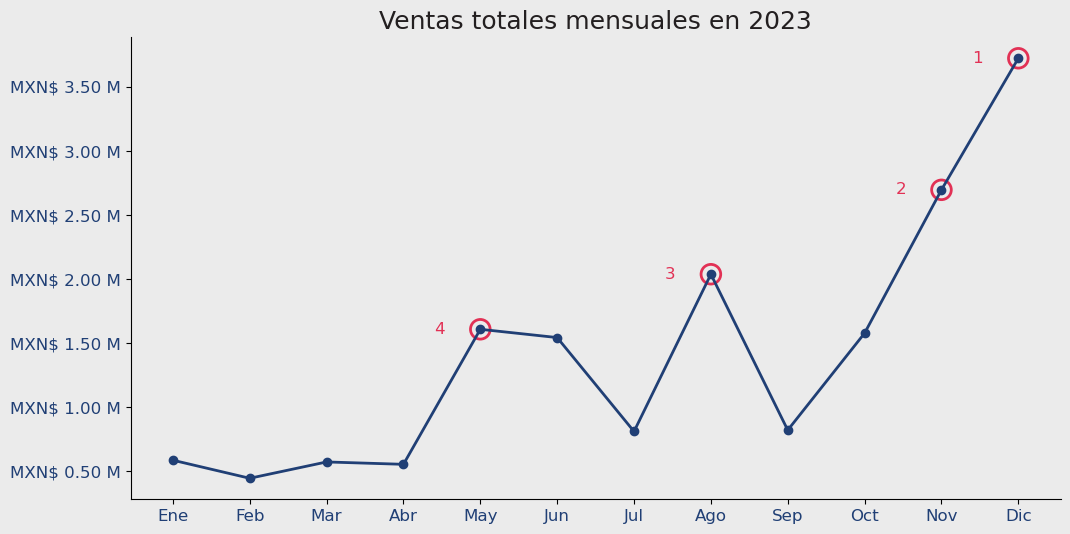

In [18]:
ventas_mensuales().show()

## Gráfico 3: Facturación por categoría de producto en 2023

```python
# 1. Crear una columna de facturación total por compra
df["facturacion"] = df["precio_unitario"] * df["cantidad"] + df["envio"]

# 2. Agrupar por categoría y sumar la facturación
facturacion_categoria = df.groupby("categoria")["facturacion"].sum().sort_values()

# 3. Visualización en barras horizontales
plt.figure(figsize=(10, 6))
sns.barplot(
    x=facturacion_categoria.values, y=facturacion_categoria.index, palette="viridis"
)

plt.title("Facturación por Categoría de Producto")
plt.xlabel("Facturación Total (MXN)")
plt.ylabel("Categoría")
plt.tight_layout()
plt.show()

```

### Mejorando el gráfico

#### Prompt

Ahora, vamos refinar el gráfico de facturación por categoría. Recuerda que este gráfico fue de barras horizontales.

El script original del gráfico es el siguiente:

```python
# 1. Crear una columna de facturación total por compra
df["facturacion"] = df["precio_unitario"] * df["cantidad"] + df["envio"]

# 2. Agrupar por categoría y sumar la facturación
facturacion_categoria = df.groupby("categoria")["facturacion"].sum().sort_values()

# 3. Visualización en barras horizontales
plt.figure(figsize=(10, 6))
sns.barplot(
    x=facturacion_categoria.values, y=facturacion_categoria.index, palette="viridis"
)

plt.title("Facturación por Categoría de Producto")
plt.xlabel("Facturación Total (MXN)")
plt.ylabel("Categoría")
plt.tight_layout()
plt.show()

```
Nuestro gráfico debe seguir la identidad visual de Zoop, con el fondo de la figura y del gráfico en el color GRIS_1, las barras en el color AQUA_1 y el tamaño de la figura debe ser de (10, 6).

El título de la figura es "Facturación por categoría de producto en 2023" con tamaño 18 y su color GRIS_5.

Las etiquetas del eje x (xticks) deben ser suprimidas al igual que los labels de los ejes x y y (xlabel y ylabel), y las etiquetas del eje y (yticks) deben tener tamaño 12 con el color AZUL_1. Todas las bordes del gráfico deben ser suprimidas.

Además, es necesario mostrar el total de la facturación de cada categoría al lado derecho de cada barra, con el texto también en color AZUL_1 y tamaño 12.

También vamos a agregar un texto dentro del área del gráfico. Para ello, divide el valor de la 1ª barra entre la suma de todas las barras y conviértelo en un porcentaje, almacenándolo en la variable "porcentaje".

Ahora, en la posición x = 0.4e7 y y = 5, agrega el siguiente texto con tamaño 12 y color AZUL_3: f"$\\bf{porcentaje:.2f}$% de las ventas corresponden únicamente a las ventas de Electrónica.\nEsto equivale a casi el doble en relación con todas las demás categorías\npresentes en el portafolio de Zoop.".

Utiliza las bibliotecas de visualización de datos de Python para crear esta visualización.

#### Respuesta

Aquí tienes el código refinado que genera el gráfico de **facturación por categoría de producto en 2023**, cumpliendo con los requerimientos visuales de identidad Zoop y la anotación especial sobre el desempeño de la categoría "Electrónica":

---

### ✅ Código actualizado con estilo Zoop:

```python
import matplotlib.pyplot as plt
import seaborn as sns

# Colores corporativos
ROJO_1, ROJO_2, ROJO_3 = "#e23155", "#cc2c4e", "#b32742"
AZUL_1, AZUL_2, AZUL_3 = "#203f75", "#1c3867", "#19325b"
BLANCO, GRIS_1, GRIS_2, GRIS_3, GRIS_4, GRIS_5 = (
    "#ffffff", "#ebebeb", "#d9d9d9", "#cccccc", "#555655", "#231f20"
)
AQUA_1, AQUA_2, AQUA_3 = "#addcd4", "#9fccc5", "#96bfb9"

# 1. Crear columna de facturación total por compra
df["facturacion"] = df["precio_unitario"] * df["cantidad"] + df["envio"]

# 2. Agrupar por categoría y ordenar por facturación
facturacion_categoria = df.groupby("categoria")["facturacion"].sum().sort_values()

# 3. Calcular porcentaje de la categoría con mayor facturación
mayor_categoria_valor = facturacion_categoria.values[-1]
porcentaje = (mayor_categoria_valor / facturacion_categoria.sum()) * 100

# 4. Visualización personalizada
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=facturacion_categoria.values,
    y=facturacion_categoria.index,
    palette=[AQUA_1] * len(facturacion_categoria)
)

# Estilo general
ax.set_facecolor(GRIS_1)
plt.gcf().set_facecolor(GRIS_1)
plt.title("Facturación por categoría de producto en 2023", fontsize=18, color=GRIS_5)

# Ejes
ax.tick_params(axis="y", labelsize=12, colors=AZUL_1)
ax.tick_params(axis="x", bottom=False, labelbottom=False)
ax.set_xlabel("")
ax.set_ylabel("")

# Quitar bordes
sns.despine(left=True, bottom=True, right=True, top=True)

# Mostrar valores al final de cada barra
for i, valor in enumerate(facturacion_categoria.values):
    ax.text(
        valor + 1e5,  # pequeña separación a la derecha de la barra
        i,
        f"$MXN{valor/1e6:.2f}M",
        va="center",
        fontsize=12,
        color=AZUL_1
    )

# Añadir texto explicativo
plt.text(
    0.4e7,
    5,
    f"$\\bf{{{porcentaje:.2f}}}$% de las ventas corresponden únicamente a las ventas de Electrónica.\n"
    "Esto equivale a casi el doble en relación con todas las demás categorías\n"
    "presentes en el portafolio de Zoop.",
    fontsize=12,
    color=AZUL_3
)

plt.tight_layout()
plt.show()
```

---

### 🎯 ¿Qué incluye este gráfico?

* ✅ Fondo de figura y área de gráfico en `GRIS_1`
* ✅ Barras horizontales en `AQUA_1`
* ✅ Etiquetas del eje Y en `AZUL_1`, tamaño 12
* ✅ Texto de facturación en formato `MXN` millones al lado derecho
* ✅ Título con estilo Zoop: tamaño 18 y color `GRIS_5`
* ✅ Anotación estratégica dentro del área del gráfico resaltando la participación de "Electrónica"

¿Deseas adaptar este mismo estilo para otro tipo de desagregación, como por marca o tipo de envío?

In [48]:
def facturacion_por_categoria():
    # 1. Crear columna de facturación total por compra
    df["facturacion"] = df["precio_unitario"] * df["cantidad"] + df["envio"]

    # 2. Agrupar por categoría y ordenar por facturación
    facturacion_categoria = df.groupby("categoria")["facturacion"].sum().sort_values()

    # 3. Calcular porcentaje de la categoría con mayor facturación
    mayor_categoria_valor = facturacion_categoria.values[-1]
    porcentaje = (mayor_categoria_valor / facturacion_categoria.sum()) * 100

    # 4. Visualización personalizada
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        x=facturacion_categoria.values,
        y=facturacion_categoria.index,
        palette=[AQUA_1] * len(facturacion_categoria),
    )

    # Estilo general
    ax.set_facecolor(GRIS_1)
    plt.gcf().set_facecolor(GRIS_1)
    plt.title("Facturación por categoría de producto en 2023", fontsize=18, color=GRIS_5)

    # Ejes
    ax.tick_params(axis="y", labelsize=12, colors=AZUL_1)
    ax.tick_params(axis="x", bottom=False, labelbottom=False)
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Quitar bordes
    sns.despine(left=True, bottom=True, right=True, top=True)

    # Mostrar valores al final de cada barra
    for i, valor in enumerate(facturacion_categoria.values):
        ax.text(
            valor + 1e5,  # pequeña separación a la derecha de la barra
            i,
            f"MXN${valor/1e6:.2f}M",
            va="center",
            fontsize=12,
            color=AZUL_1,
        )

    # Añadir texto explicativo
    plt.text(
        0.4e7,
        1.4,  # modificado
        f"$\\bf{{{porcentaje:.2f}}}$% de las ventas corresponden únicamente a las ventas\n de Electrónica."
        "Esto equivale a casi el doble en relación con\n todas las demás categorías"
        "presentes en el portafolio de Zoop.",
        fontsize=12,
        color=AZUL_3,
    )

    plt.tight_layout()
    return plt

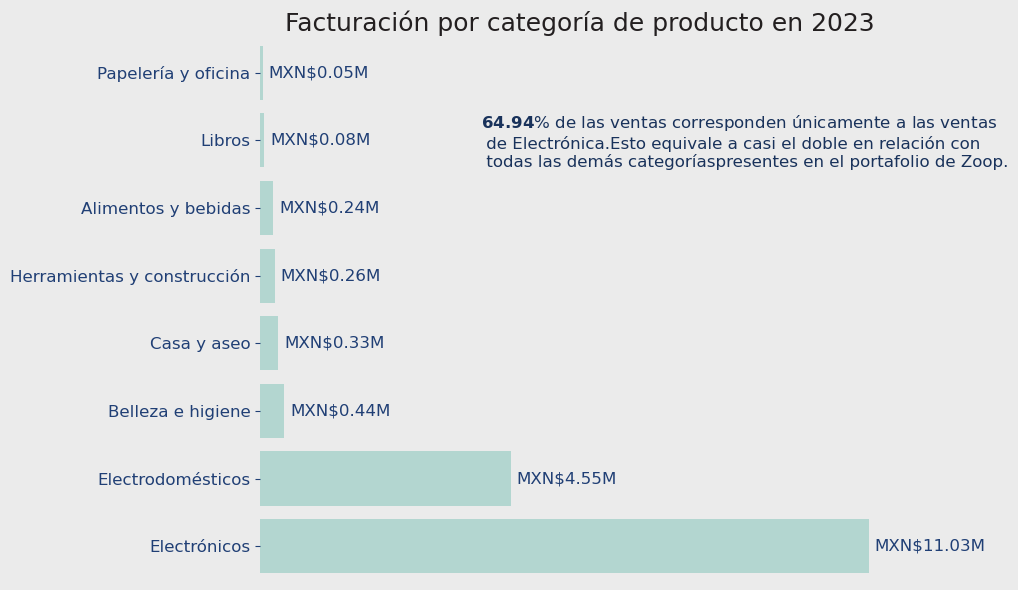

In [46]:
facturacion_por_categoria().show()

## Gráfico 4: Ventas por trimestre y método de pago

### Prompt

Ahora vamos con el gráfico de Ventas por Trimestre y Método de Pago que producimos anteriormente. Vamos a refinarlo usando las siguientes directrices.

Recuerda que el script original del gráfico es el siguiente:
```python
# 1. Asegurar que 'fecha' es datetime
df["fecha"] = pd.to_datetime(df["fecha"])

# 2. Crear columna de trimestre (formato 'T1', 'T2', etc.)
df["trimestre"] = df["fecha"].dt.to_period("Q").astype(str).str.replace("2023Q", "T")

# 3. Agrupar por trimestre y método de pago, sumando facturación
ventas_trimestre = (
    df.groupby(["trimestre", "metodo_pago"])["facturacion"].sum().unstack(fill_value=0)
)

# 4. Crear gráfico de barras apiladas
ventas_trimestre.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="tab20c")

plt.title("Facturación por Trimestre y Método de Pago - Zoop")
plt.xlabel("Trimestre")
plt.ylabel("Facturación")
plt.legend(title="Método de Pago por trimestre de 2023")

# Rotar etiquetas del eje X
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
```

Nuestro gráfico debe seguir la identidad visual de Zoop, con el fondo de la figura y del gráfico en el color GRIS_1 y el tamaño de la figura debe ser de (10, 6). La secuencia de colores de las columnas apiladas (palette) es [BLANCO, GRIS_3, GRIS_1, GRIS_3].

El título de la figura es "Ventas por Trimestre y Método de Pago en 2023" con tamaño 18 y su color GRIS_5.

Las etiquetas del eje x (xticks) deben estar a 0 grados y tener tamaño 12 con el color AZUL_1. Las etiquetas del eje y (yticks) deben estar en el formato f"MXN$ valor M" sin decimales y las etiquetas de los ejes x e y (xlabel e ylabel) deben ser suprimidas. Todos los bordes del gráfico deben ser suprimidos(['top','bottom','left','right]).

También agrega una cuadrícula punteada en y.

Utiliza las bibliotecas de visualización de datos de Python para crear esta visualización.

### Respuesta

Aquí tienes el gráfico de **Ventas por Trimestre y Método de Pago en 2023** completamente refinado para seguir la identidad visual de Zoop, utilizando `matplotlib` y `pandas`.

---

### ✅ Código Refinado:

```python
import pandas as pd
import matplotlib.pyplot as plt

# Colores institucionales Zoop
ROJO_1, ROJO_2, ROJO_3 = "#e23155", "#cc2c4e", "#b32742"
AZUL_1, AZUL_2, AZUL_3 = "#203f75", "#1c3867", "#19325b"
BLANCO, GRIS_1, GRIS_2, GRIS_3, GRIS_4, GRIS_5 = (
    "#ffffff", "#ebebeb", "#d9d9d9", "#cccccc", "#555655", "#231f20"
)
AQUA_1, AQUA_2, AQUA_3 = "#addcd4", "#9fccc5", "#96bfb9"

# 1. Asegurar que 'fecha' es datetime
df["fecha"] = pd.to_datetime(df["fecha"])

# 2. Crear columna de trimestre
df["trimestre"] = df["fecha"].dt.to_period("Q").astype(str).str.replace("2023Q", "T")

# 3. Agrupar por trimestre y método de pago
ventas_trimestre = (
    df.groupby(["trimestre", "metodo_pago"])["facturacion"]
    .sum()
    .unstack(fill_value=0)
)

# 4. Colores personalizados
colores = [BLANCO, GRIS_3, GRIS_1, GRIS_3]  # Si hay más métodos, se repetirá

# 5. Crear gráfico apilado
fig, ax = plt.subplots(figsize=(10, 6), facecolor=GRIS_1)
ventas_trimestre.plot(
    kind="bar",
    stacked=True,
    ax=ax,
    color=colores,
    edgecolor=GRIS_1,
)

# 6. Personalización visual
ax.set_facecolor(GRIS_1)
ax.set_title("Ventas por Trimestre y Método de Pago en 2023", fontsize=18, color=GRIS_5)

# Eje X
ax.set_xlabel("")
ax.set_xticklabels(ventas_trimestre.index, fontsize=12, color=AZUL_1, rotation=0)

# Eje Y
ax.set_ylabel("")
yticks_mxn = [f"MXN${int(y / 1e6)}M" for y in ax.get_yticks()]
ax.set_yticklabels(yticks_mxn, fontsize=12, color=AZUL_1)

# Leyenda
ax.legend(title="Método de Pago por trimestre de 2023", loc="upper left")

# Bordes eliminados
for spine in ["top", "bottom", "left", "right"]:
    ax.spines[spine].set_visible(False)

# Cuadrícula punteada en Y
ax.yaxis.grid(True, linestyle=":", color=GRIS_3)
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()
```

---

### 🎯 ¿Qué logramos?

* Gráfico limpio, corporativo y legible.
* Estilo apilado para comparar métodos de pago dentro de cada trimestre.
* Etiquetas en millones (`MXN$`) y cuadrícula sutil para facilitar el análisis.
* Diseño profesional completamente alineado con la identidad visual de Zoop.

¿Te gustaría hacer una versión interactiva en Plotly o destacar algún método de pago específico con otro color?

In [54]:
def ventas_por_trimestre():
    # 1. Asegurar que 'fecha' es datetime
    df["fecha"] = pd.to_datetime(df["fecha"])

    # 2. Crear columna de trimestre
    df["trimestre"] = df["fecha"].dt.to_period("Q").astype(str).str.replace("2023Q", "T")

    # 3. Agrupar por trimestre y método de pago
    ventas_trimestre = (
        df.groupby(["trimestre", "metodo_pago"])["facturacion"].sum().unstack(fill_value=0)
    )

    # 4. Colores personalizados
    colores = [BLANCO, GRIS_3, AQUA_1, AQUA_3]  # Si hay más métodos, se repetirá #modificado

    # 5. Crear gráfico apilado
    fig, ax = plt.subplots(figsize=(10, 6), facecolor=GRIS_1)
    ventas_trimestre.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=colores,
        edgecolor=GRIS_1,
    )

    # 6. Personalización visual
    ax.set_facecolor(GRIS_1)
    ax.set_title("Ventas por Trimestre y Método de Pago en 2023", fontsize=18, color=GRIS_5)

    # Eje X
    ax.set_xlabel("")
    ax.set_xticklabels(ventas_trimestre.index, fontsize=12, color=AZUL_1, rotation=0)

    # Eje Y
    ax.set_ylabel("")
    yticks_mxn = [f"MXN${int(y / 1e6)}M" for y in ax.get_yticks()]
    ax.set_yticklabels(yticks_mxn, fontsize=12, color=AZUL_1)

    # Leyenda
    ax.legend(title="Método de Pago por trimestre de 2023", loc="upper left")

    # Bordes eliminados
    for spine in ["top", "bottom", "left", "right"]:
        ax.spines[spine].set_visible(False)

    # Cuadrícula punteada en Y
    ax.yaxis.grid(True, linestyle=":", color=GRIS_3)
    ax.xaxis.grid(False)

    plt.tight_layout()
    return plt

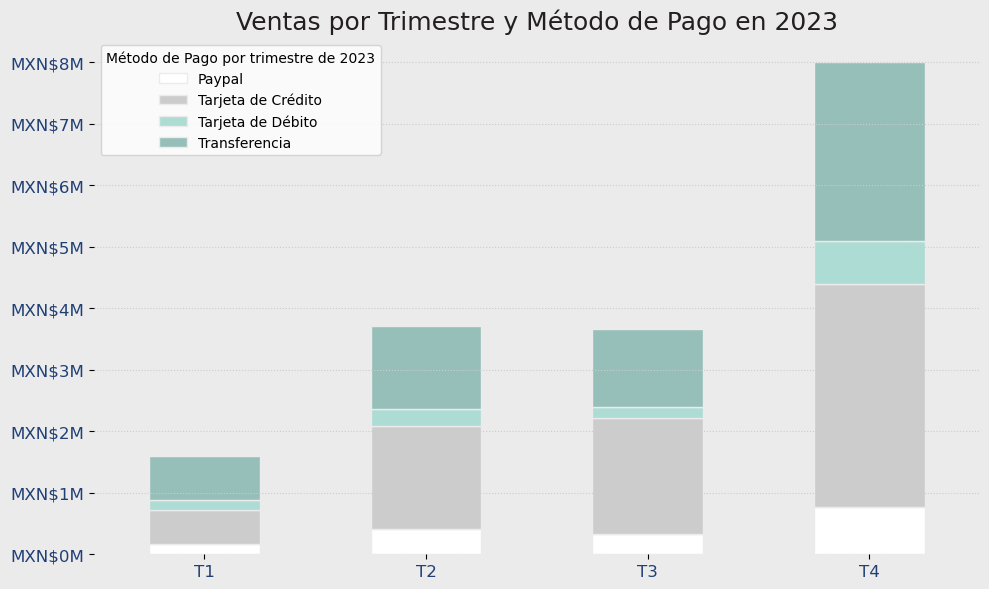

In [55]:
ventas_por_trimestre().show()

#### Comentarios
---
Ajustamos el gráfico de barras apiladas representando con colores más suaves los valores de los métodos de pago. Podemos notar cosas interesantes en este gráfico, como: el 2º y 4º trimestre siendo los momentos en que Zoop factura más con ventas, y también el aumento en los pagos de las compras realizadas por los clientes mediante tarjeta de crédito.

## Gráfico 5: Clientes participantes del programa de cashback

In [57]:
import plotly.express as px

# Contar cuántos clientes participan o no en el programa
cashback_counts = df["cashback"].value_counts().reset_index()
cashback_counts.columns = ["Participa", "Cantidad"]

# Crear diccionario de colores personalizados
colores_personalizados = {"Sí": "#2ecc71", "No": "#e74c3c"}  # Verde  # Rojo

# Definir explosión para separar las secciones del gráfico
pull_valores = [0.1 if val == "Sí" else 0.05 for val in cashback_counts["Participa"]]

# Crear gráfico circular con colores y separación
fig = px.pie(
    cashback_counts,
    names="Participa",
    values="Cantidad",
    title="Proporción de participación en el programa de cashback de Zoop",
    color="Participa",
    color_discrete_map=colores_personalizados,
    # hole=0.3,
)

# Aplicar la separación (pull)
fig.update_traces(pull=pull_valores)

# Mostrar gráfico interactivo
fig.show()

### Prompt

Ahora, vamos a refinar el gráfico de dona que produjimos para la proporción de usuarios que se adhieren al programa de cashback.

Recuerda que el script original del gráfico es el siguiente:

```python
import plotly.express as px

# Contar cuántos clientes participan o no en el programa
cashback_counts = df["cashback"].value_counts().reset_index()
cashback_counts.columns = ["Participa", "Cantidad"]

# Crear diccionario de colores personalizados
colores_personalizados = {"Sí": "#2ecc71", "No": "#e74c3c"}  # Verde  # Rojo

# Definir explosión para separar las secciones del gráfico
pull_valores = [0.1 if val == "Sí" else 0.05 for val in cashback_counts["Participa"]]

# Crear gráfico circular con colores y separación
fig = px.pie(
    cashback_counts,
    names="Participa",
    values="Cantidad",
    title="Proporción de participación en el programa de cashback de Zoop",
    color="Participa",
    color_discrete_map=colores_personalizados,
    # hole=0.3,
)

# Aplicar la separación (pull)
fig.update_traces(pull=pull_valores)

# Mostrar gráfico interactivo
fig.show()
```

Nuestro gráfico debe seguir la identidad visual de Zoop, debe ser un gráfico de dona con el fondo de la figura y del gráfico en el color GRIS_1, el color de la porción de valor "No" igual a GRIS_3, el color de la porción de valor "Sí" igual a AZUL_1 y el tamaño de la figura debe ser de (6, 6).

El título de la figura es "¿Participan en el programa de cashback?" con un tamaño de 18 y su color GRIS_5.

Las etiquetas de las porciones deben tener el mismo color que las porciones y un tamaño de 12, y los porcentajes deben estar en color BLANCO, también con un tamaño de 12.

La propiedad de ancho de la dona (wedgeprops) debe ser de 0.4, la posición de los porcentajes dentro de la porción (pctdistance) debe ser de 0.8, el ángulo de inicio debe ser de 180 (startangle), y sin explosión de porciones.

Utiliza las bibliotecas de visualización de datos de Python para crear esta visualización.

### Respuesta

Aquí tienes el gráfico de dona refinado sobre la participación en el programa de cashback de Zoop, **siguiendo fielmente la identidad visual de Zoop y todos los parámetros solicitados**, utilizando **`matplotlib`**:

---

### ✅ Código con `matplotlib`:

```python
import pandas as pd
import matplotlib.pyplot as plt

# Colores institucionales Zoop
ROJO_1, ROJO_2, ROJO_3 = "#e23155", "#cc2c4e", "#b32742"
AZUL_1, AZUL_2, AZUL_3 = "#203f75", "#1c3867", "#19325b"
BLANCO, GRIS_1, GRIS_2, GRIS_3, GRIS_4, GRIS_5 = (
    "#ffffff", "#ebebeb", "#d9d9d9", "#cccccc", "#555655", "#231f20"
)
AQUA_1, AQUA_2, AQUA_3 = "#addcd4", "#9fccc5", "#96bfb9"

# Contar participación en programa cashback
cashback_counts = df["cashback"].value_counts().reset_index()
cashback_counts.columns = ["Participa", "Cantidad"]

# Preparar datos para el gráfico
labels = cashback_counts["Participa"]
sizes = cashback_counts["Cantidad"]
colors = [AZUL_1 if label == "Sí" else GRIS_3 for label in labels]

# Crear gráfico de dona
fig, ax = plt.subplots(figsize=(6, 6), facecolor=GRIS_1)
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    colors=colors,
    startangle=180,
    wedgeprops={"width": 0.4},
    pctdistance=0.8,
    autopct="%1.0f%%",
    textprops={"fontsize": 12, "weight": "bold"},
)

# Personalizar etiquetas y porcentajes
for text, label in zip(texts, labels):
    text.set_color(AZUL_1 if label == "Sí" else GRIS_3)
    text.set_fontsize(12)
for autotext in autotexts:
    autotext.set_color(BLANCO)
    autotext.set_fontsize(12)

# Fondo del gráfico
ax.set_facecolor(GRIS_1)
fig.patch.set_facecolor(GRIS_1)

# Título
plt.title("¿Participan en el programa de cashback?", fontsize=18, color=GRIS_5)

plt.tight_layout()
plt.show()
```

---

### 🎯 Ajustes realizados:

* ✅ Dona de grosor 0.4 (`wedgeprops`).
* ✅ Inicio en 180° (`startangle=180`).
* ✅ Sin explosiones.
* ✅ Colores Zoop: `AZUL_1` y `GRIS_3`.
* ✅ Porcentajes en blanco (`BLANCO`) y etiquetas del mismo color de sus porciones.
* ✅ Estilo sobrio y profesional con fondo `GRIS_1`.

¿Quieres agregar una anotación dentro de la dona o exportar este gráfico como imagen?

In [ ]:
def proporcion_cashback():
    # Contar participación en programa cashback
    cashback_counts = df["cashback"].value_counts().reset_index()
    cashback_counts.columns = ["Participa", "Cantidad"]

    # Preparar datos para el gráfico
    labels = cashback_counts["Participa"]
    sizes = cashback_counts["Cantidad"]
    colors = [AZUL_1 if label == "Sí" else GRIS_3 for label in labels]

    # Crear gráfico de dona
    fig, ax = plt.subplots(figsize=(6, 6), facecolor=GRIS_1)
    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=labels,
        colors=colors,
        startangle=180,
        wedgeprops={"width": 0.4},
        pctdistance=0.8,
        autopct="%1.0f%%",
        textprops={"fontsize": 12, "weight": "bold"},
    )

    # Personalizar etiquetas y porcentajes
    for text, label in zip(texts, labels):
        text.set_color(AZUL_1 if label == "Sí" else GRIS_3)
        text.set_fontsize(12)
    for autotext in autotexts:
        autotext.set_color(BLANCO)
        autotext.set_fontsize(12)

    # Fondo del gráfico
    ax.set_facecolor(GRIS_1)
    fig.patch.set_facecolor(GRIS_1)

    # Título
    plt.title("¿Participan en el programa de cashback?", fontsize=18, color=GRIS_5)

    plt.tight_layout()
    return plt

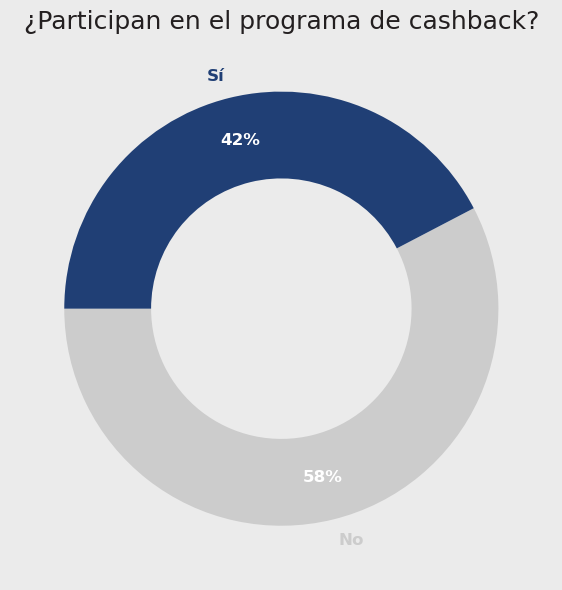

In [61]:
proporcion_cashback().show()

## Gráfico 6: Evaluaciones de los productos:

In [62]:
import plotly.express as px

# Crear histograma con Plotly
fig = px.histogram(
    df,
    x="nota",
    nbins=11,  # de 0 a 10, enteros
    title="Distribución de las calificaciones del público",
    labels={"nota": "Calificación", "count": "Cantidad"},
    color_discrete_sequence=["#3498db"],
)

fig.update_layout(bargap=0.2)  # separación entre barras
fig.show()

### Prompt

Ahora vamos con el gráfico de la Distribución de las Evaluaciones de Compra que produjimos anteriormente. Vamos a refinarlo usando las siguientes orientaciones.

El script original que genera el gráfico es el siguiente:

```python
# Crear histograma con Plotly
fig = px.histogram(
    df,
    x="nota",
    nbins=11,  # de 0 a 10, enteros
    title="Distribución de las calificaciones del público",
    labels={"nota": "Calificación", "count": "Cantidad"},
    color_discrete_sequence=["#3498db"],
)

fig.update_layout(bargap=0.2)  # separación entre barras
fig.show()
```

Nuestro gráfico necesita seguir la identidad visual de Zoop, con el fondo de la figura y del gráfico en el color GRIS_1, el color de las columnas en ROJO_1 y el tamaño de la figura debe ser de (10, 6).

El título de la figura es "Distribución de las evaluaciones de las compras en 2023" con tamaño 18 y su color GRIS_5.

Las etiquetas del eje x (xticks) deben estar en el rango de 0 a 10 con 11 bins y tener tamaño 12 con el color AZUL_1. Las etiquetas del eje y (yticks) deben tener tamaño 12 con el color AZUL_1 y las etiquetas de los ejes x e y (xlabel e ylabel) también deben tener tamaño 12 con el color AZUL_1. Todos los bordes del gráfico deben ser suprimidos (['top', 'bottom', 'left', 'right']).

El grid del eje y debe estar detrás del gráfico (ax.set_axisbelow(True)).

Vamos a añadir una caja de anotación (ax.annotate()) con el fondo en color BLANCO y el borde en color GRIS_3 dentro del área del gráfico. El texto de la anotación es

f"Promedio de calificaciones = {df['nota'].mean().round(2)}\n Calificación más común = {df['nota'].value_counts().idxmax()}\n Frecuencia más común = {df['nota'].value_counts().max()}"
en color AZUL_1. Añade la caja de anotación con el texto en la posición xytext=(2, 1800) y coloca una flecha, en color AZUL_1, saliendo de la caja hasta la posición xy=(8.7, 2250).

Utiliza las bibliotecas de visualización de datos de Python para crear esta visualización.

### Respuesta

Aquí tienes el gráfico refinado de **distribución de las evaluaciones de compra en 2023**, ahora totalmente ajustado a la **identidad visual de Zoop** y usando únicamente **`matplotlib`**:

---

### ✅ Código con `matplotlib`:

```python
import matplotlib.pyplot as plt
import pandas as pd

# Paleta de colores institucional Zoop
ROJO_1 = "#e23155"
AZUL_1 = "#203f75"
GRIS_1 = "#ebebeb"
GRIS_3 = "#cccccc"
GRIS_5 = "#231f20"
BLANCO = "#ffffff"

# Crear histograma personalizado
fig, ax = plt.subplots(figsize=(10, 6), facecolor=GRIS_1)

# Histograma con 11 bins (0 a 10)
n, bins, patches = ax.hist(
    df["nota"],
    bins=11,
    color=ROJO_1,
    edgecolor=GRIS_1
)

# Ajustes del área del gráfico
ax.set_facecolor(GRIS_1)
ax.set_axisbelow(True)  # Grid detrás de las barras

# Título
ax.set_title(
    "Distribución de las evaluaciones de las compras en 2023",
    fontsize=18,
    color=GRIS_5
)

# Ejes y etiquetas
ax.set_xlabel("Calificación", fontsize=12, color=AZUL_1)
ax.set_ylabel("Cantidad", fontsize=12, color=AZUL_1)

# Personalizar xticks y yticks
ax.set_xticks(range(0, 11))
ax.tick_params(axis="x", labelsize=12, colors=AZUL_1)
ax.tick_params(axis="y", labelsize=12, colors=AZUL_1)

# Grid en el eje y
ax.yaxis.grid(True, linestyle="--", color=GRIS_3)

# Eliminar bordes
for spine in ["top", "bottom", "left", "right"]:
    ax.spines[spine].set_visible(False)

# Calcular métricas para anotación
media = df["nota"].mean().round(2)
moda = df["nota"].value_counts().idxmax()
frecuencia = df["nota"].value_counts().max()

# Anotación con flecha
texto = (
    f"Promedio de calificaciones = {media}\n"
    f"Calificación más común = {moda}\n"
    f"Frecuencia más común = {frecuencia}"
)
ax.annotate(
    texto,
    xy=(8.7, 2250),  # Punto final de la flecha
    xytext=(2, 1800),  # Posición de la caja
    textcoords="data",
    fontsize=12,
    color=AZUL_1,
    ha="left",
    bbox=dict(boxstyle="round", facecolor=BLANCO, edgecolor=GRIS_3),
    arrowprops=dict(arrowstyle="->", color=AZUL_1)
)

plt.tight_layout()
plt.show()
```

---

### ✅ Ajustes aplicados:

* 🎯 Fondo general y área del gráfico: `GRIS_1`.
* 🔴 Color de las barras: `ROJO_1`.
* 📌 Título en `GRIS_5`, tamaño 18.
* 🔠 Etiquetas y ticks en `AZUL_1`, tamaño 12.
* 🧾 Anotación con flecha personalizada destacando métricas clave.
* 🚫 Eliminados todos los bordes del gráfico.
* ✅ Grid punteado detrás de las barras.

¿Quieres exportarlo a PDF o agregarlo a un dashboard interactivo?

In [64]:
def distribucion_calificaciones():
    # Crear histograma personalizado
    fig, ax = plt.subplots(figsize=(10, 6), facecolor=GRIS_1)

    # Histograma con 11 bins (0 a 10)
    n, bins, patches = ax.hist(df["nota"], bins=11, color=ROJO_1, edgecolor=GRIS_1)

    # Ajustes del área del gráfico
    ax.set_facecolor(GRIS_1)
    ax.set_axisbelow(True)  # Grid detrás de las barras

    # Título
    ax.set_title(
        "Distribución de las evaluaciones de las compras en 2023", fontsize=18, color=GRIS_5
    )

    # Ejes y etiquetas
    ax.set_xlabel("Calificación", fontsize=12, color=AZUL_1)
    ax.set_ylabel("Cantidad", fontsize=12, color=AZUL_1)

    # Personalizar xticks y yticks
    ax.set_xticks(range(0, 11))
    ax.tick_params(axis="x", labelsize=12, colors=AZUL_1)
    ax.tick_params(axis="y", labelsize=12, colors=AZUL_1)

    # Grid en el eje y
    ax.yaxis.grid(True, linestyle="--", color=GRIS_3)

    # Eliminar bordes
    for spine in ["top", "bottom", "left", "right"]:
        ax.spines[spine].set_visible(False)

    # Calcular métricas para anotación
    media = df["nota"].mean().round(2)
    moda = df["nota"].value_counts().idxmax()
    frecuencia = df["nota"].value_counts().max()

    # Anotación con flecha
    texto = (
        f"Promedio de calificaciones = {media}\n"
        f"Calificación más común = {moda}\n"
        f"Frecuencia más común = {frecuencia}"
    )
    ax.annotate(
        texto,
        xy=(8.7, 2250),  # Punto final de la flecha
        xytext=(2, 1800),  # Posición de la caja
        textcoords="data",
        fontsize=12,
        color=AZUL_1,
        ha="left",
        bbox=dict(boxstyle="round", facecolor=BLANCO, edgecolor=GRIS_3),
        arrowprops=dict(arrowstyle="->", color=AZUL_1),
    )

    plt.tight_layout()
    return plt

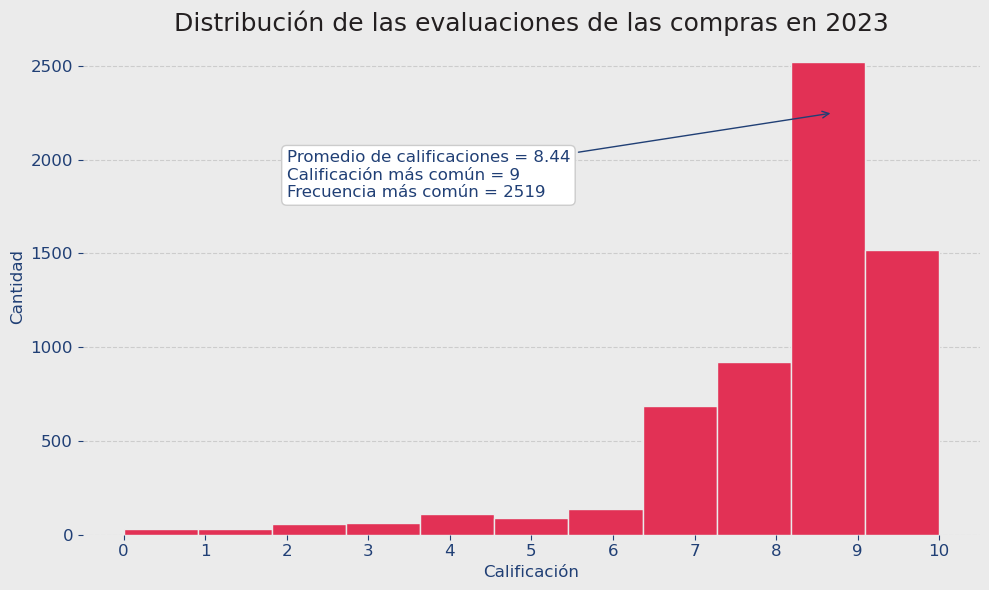

In [65]:
distribucion_calificaciones().show()

## Gráfico 7: Distribución del público por edad y sexo biológico

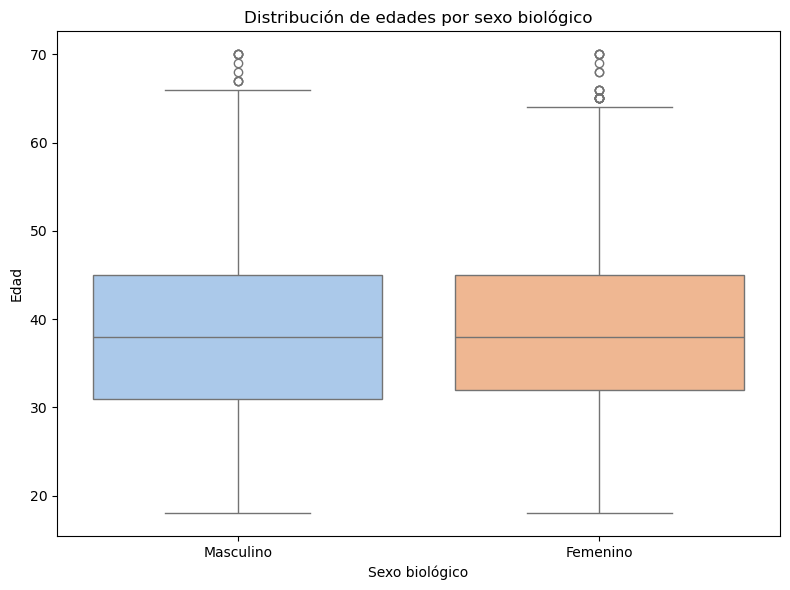

In [66]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="sexo_biologico", y="edad", palette="pastel")

plt.title("Distribución de edades por sexo biológico")
plt.xlabel("Sexo biológico")
plt.ylabel("Edad")
plt.tight_layout()
plt.show()

### Prompt

Ahora vamos al gráfico de boxplot de la Distribución de la Edad por Sexo Biológico que produjimos anteriormente. Vamos a refinado usando las siguientes orientaciones.

El script original que genera el gráfico es el siguiente:

```python
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="sexo_biologico", y="edad", palette="pastel")

plt.title("Distribución de edades por sexo biológico")
plt.xlabel("Sexo biológico")
plt.ylabel("Edad")
plt.tight_layout()
plt.show()
```

Nuestro gráfico debe seguir la identidad visual de Zoop, con el fondo de la figura y del gráfico en el color GRIS_1, y el tamaño de la figura debe ser de (10, 6).

El título de la figura es "Distribución de la Edad por Sexo Biológico de los clientes" con tamaño 18 y su color GRIS_5.

La columna 'sexo_biologico' está representada en el eje x y la 'edad' en el eje y. La paleta de colores para los valores de x es [AZUL_1, AQUA_1].

La etiqueta del eje x (xlabel) debe ser suprimida. Los rótulos del eje x y y (xticks y yticks) deben tener tamaño 12 con el color AZUL_1 y la etiqueta del eje y (ylabel) también debe tener tamaño 12 con el color AZUL_1. Todos los bordes del gráfico deben ser suprimidos y la cuadrícula del eje y debe estar detrás del gráfico (ax.set_axisbelow(True)).

Vamos a agregar dos cajas de anotación (ax.annotate()) con el fondo en color BLANCO y el borde en color GRIS_3 dentro del área del gráfico.

El texto de la primera anotación en color AZUL_1 es

f"Mínimo = df.groupby("sexo_biologico")["edad"].min()[1]\n 1º quartil = df.groupby("sexo_biologico")["edad"].quantile(.25)[1]\n 2º quartil = df.groupby("sexo_biologico")["edad"].median()[1]\n 3º quartil = df.groupby("sexo_biologico")["edad"].quantile(.75)[1]\n Máximo = df.groupby("sexo_biologico")["edad"].max()[1]"
Agrega la caja de anotación con el texto en la posición xytext=(-0.4, 50) y coloca una flecha, en color AZUL_1, saliendo de la caja hasta la posición xy=(-0.1, 45).

El texto de la segunda anotación en color AZUL_1 es

f"Mínimo = df.groupby("sexo_biologico")["edad"].min()[0]\n 1º quartil = df.groupby("sexo_biologico")["edad"].quantile(.25)[0]\n 2º quartil = df.groupby("sexo_biologico")["edad"].median()[0]\n 3º quartil = df.groupby("sexo_biologico")["edad"].quantile(.75)[0]\n Máximo = df.groupby("sexo_biologico")["edad"].max()[0]"
Agrega la caja de anotación con el texto en la posición xytext=(0.6, 50) y coloca una flecha, en color AZUL_1, saliendo de la caja hasta la posición xy=(0.9, 45).

Utiliza las bibliotecas de visualización de datos de Python para crear esta visualización.

### Respuesta

Aquí tienes el gráfico **refinado de boxplot** para la *Distribución de la Edad por Sexo Biológico de los clientes*, siguiendo completamente la identidad visual de Zoop y usando `matplotlib` + `seaborn`:

---

### ✅ Código:

```python
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Paleta de colores institucional Zoop
AZUL_1 = "#203f75"
AQUA_1 = "#2dc6c6"
GRIS_1 = "#ebebeb"
GRIS_3 = "#cccccc"
GRIS_5 = "#231f20"
BLANCO = "#ffffff"

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(10, 6), facecolor=GRIS_1)

# Boxplot personalizado
sns.boxplot(
    data=df,
    x="sexo_biologico",
    y="edad",
    palette=[AZUL_1, AQUA_1],
    ax=ax
)

# Fondo del gráfico
ax.set_facecolor(GRIS_1)
ax.set_axisbelow(True)

# Título
ax.set_title(
    "Distribución de la Edad por Sexo Biológico de los clientes",
    fontsize=18,
    color=GRIS_5
)

# Suprimir xlabel
ax.set_xlabel("")

# Personalizar etiquetas
ax.set_ylabel("Edad", fontsize=12, color=AZUL_1)
ax.tick_params(axis="x", labelsize=12, colors=AZUL_1)
ax.tick_params(axis="y", labelsize=12, colors=AZUL_1)

# Cuadrícula en eje y
ax.yaxis.grid(True, linestyle="--", color=GRIS_3)

# Eliminar bordes
for spine in ["top", "bottom", "left", "right"]:
    ax.spines[spine].set_visible(False)

# === Anotación 1: sexo_biologico == 1 (por ejemplo, "Mujer") ===
grupo_fem = df.groupby("sexo_biologico")["edad"]
texto_1 = (
    f"Mínimo = {grupo_fem.min()[1]}\n"
    f"1º quartil = {grupo_fem.quantile(.25)[1]}\n"
    f"2º quartil = {grupo_fem.median()[1]}\n"
    f"3º quartil = {grupo_fem.quantile(.75)[1]}\n"
    f"Máximo = {grupo_fem.max()[1]}"
)
ax.annotate(
    texto_1,
    xy=(-0.1, 45),
    xytext=(-0.4, 50),
    textcoords="data",
    fontsize=12,
    color=AZUL_1,
    ha="left",
    bbox=dict(boxstyle="round", facecolor=BLANCO, edgecolor=GRIS_3),
    arrowprops=dict(arrowstyle="->", color=AZUL_1)
)

# === Anotación 2: sexo_biologico == 0 (por ejemplo, "Hombre") ===
grupo_masc = df.groupby("sexo_biologico")["edad"]
texto_2 = (
    f"Mínimo = {grupo_masc.min()[0]}\n"
    f"1º quartil = {grupo_masc.quantile(.25)[0]}\n"
    f"2º quartil = {grupo_masc.median()[0]}\n"
    f"3º quartil = {grupo_masc.quantile(.75)[0]}\n"
    f"Máximo = {grupo_masc.max()[0]}"
)
ax.annotate(
    texto_2,
    xy=(0.9, 45),
    xytext=(0.6, 50),
    textcoords="data",
    fontsize=12,
    color=AZUL_1,
    ha="left",
    bbox=dict(boxstyle="round", facecolor=BLANCO, edgecolor=GRIS_3),
    arrowprops=dict(arrowstyle="->", color=AZUL_1)
)

plt.tight_layout()
plt.show()
```

---

### ✅ Detalles aplicados:

* 📊 **Fondo** de figura y gráfico: `GRIS_1`.
* 🎨 **Colores** de los boxplots: `[AZUL_1, AQUA_1]`.
* 📌 **Título** en `GRIS_5`, tamaño 18.
* 🔠 **Etiquetas** y ticks en `AZUL_1`, tamaño 12.
* 🚫 Eliminación de todos los bordes del gráfico.
* 🔍 **Anotaciones** con estadísticas clave por sexo biológico, con flechas indicativas.
* ✅ **Grid** punteado en eje y, detrás de las cajas.

¿Te gustaría convertirlo a formato interactivo con Plotly o exportarlo como imagen para un informe?


In [ ]:
def box_plot_edad_sexo():
    # Crear figura y ejes
    fig, ax = plt.subplots(figsize=(10, 6), facecolor=GRIS_1)

    # Boxplot personalizado
    sns.boxplot(data=df, x="sexo_biologico", y="edad", palette=[AZUL_1, AQUA_1], ax=ax)

    # Fondo del gráfico
    ax.set_facecolor(GRIS_1)
    ax.set_axisbelow(True)

    # Título
    ax.set_title(
        "Distribución de la Edad por Sexo Biológico de los clientes",
        fontsize=18,
        color=GRIS_5,
    )

    # Suprimir xlabel
    ax.set_xlabel("")

    # Personalizar etiquetas
    ax.set_ylabel("Edad", fontsize=12, color=AZUL_1)
    ax.tick_params(axis="x", labelsize=12, colors=AZUL_1)
    ax.tick_params(axis="y", labelsize=12, colors=AZUL_1)

    # Cuadrícula en eje y
    ax.yaxis.grid(True, linestyle="--", color=GRIS_3)

    # Eliminar bordes
    for spine in ["top", "bottom", "left", "right"]:
        ax.spines[spine].set_visible(False)

    # === Anotación 1: sexo_biologico == 1 (por ejemplo, "Mujer") ===
    grupo_fem = df.groupby("sexo_biologico")["edad"]
    texto_1 = (
        f"Mínimo = {grupo_fem.min()[1]}\n"
        f"1º quartil = {grupo_fem.quantile(.25)[1]}\n"
        f"2º quartil = {grupo_fem.median()[1]}\n"
        f"3º quartil = {grupo_fem.quantile(.75)[1]}\n"
        f"Máximo = {grupo_fem.max()[1]}"
    )
    ax.annotate(
        texto_1,
        xy=(-0.1, 45),
        xytext=(-0.4, 50),
        textcoords="data",
        fontsize=12,
        color=AZUL_1,
        ha="left",
        bbox=dict(boxstyle="round", facecolor=BLANCO, edgecolor=GRIS_3),
        arrowprops=dict(arrowstyle="->", color=AZUL_1),
    )

    # === Anotación 2: sexo_biologico == 0 (por ejemplo, "Hombre") ===
    grupo_masc = df.groupby("sexo_biologico")["edad"]
    texto_2 = (
        f"Mínimo = {grupo_masc.min()[0]}\n"
        f"1º quartil = {grupo_masc.quantile(.25)[0]}\n"
        f"2º quartil = {grupo_masc.median()[0]}\n"
        f"3º quartil = {grupo_masc.quantile(.75)[0]}\n"
        f"Máximo = {grupo_masc.max()[0]}"
    )
    ax.annotate(
        texto_2,
        xy=(0.9, 45),
        xytext=(0.6, 50),
        textcoords="data",
        fontsize=12,
        color=AZUL_1,
        ha="left",
        bbox=dict(boxstyle="round", facecolor=BLANCO, edgecolor=GRIS_3),
        arrowprops=dict(arrowstyle="->", color=AZUL_1),
    )

    plt.tight_layout()
    return plt

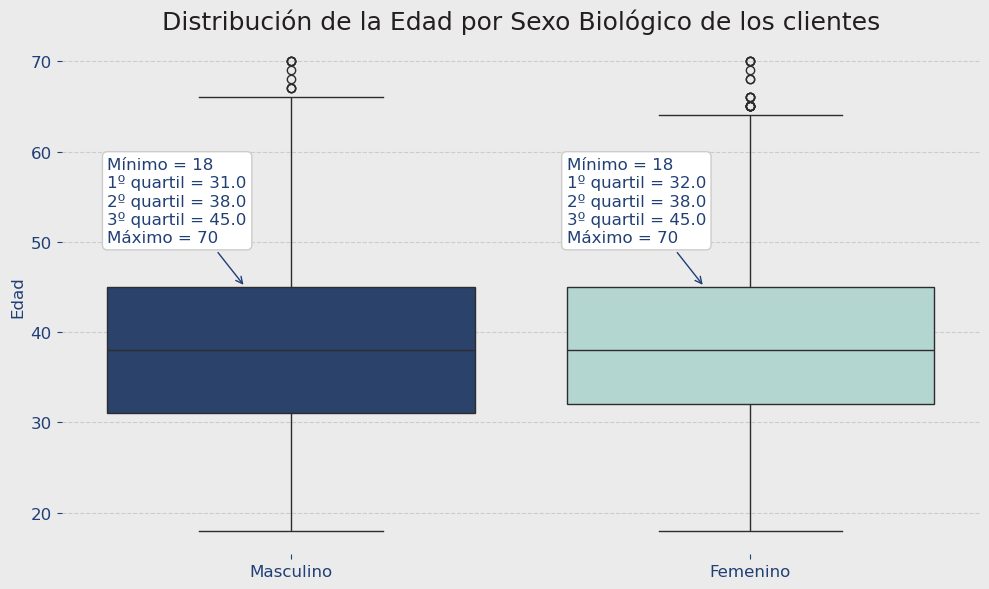

In [69]:
box_plot_edad_sexo().show()

# Exportando los gráficos

### Prompt

Ahora, vamos a nuestra última etapa: guardar las visualizaciones como imagen.

Genera una función para poder exportar los gráficos que hemos ido construyendo. Cada gráfico fue almacenado en otra función aparte y la idea es llamar a esta función usando la función de cada gráfico como parámetro para poder hacer la exportación, te sugiero seguir estos pasos para la función exportadora de gráficos:

```python
nombre_imagen = nombre_funcion()
nombre_imagen.savefig('nombre_imagen.png', bbox_inches='tight')
nombre_imagen.close()
```

Las funciones creadas para generar los gráficos son:

- metodo_pago()
- ventas_mensuales()
- facturacion_por_categoria()
- ventas_por_trimestre()
- proporcion_cashback()
- distribucion_calificaciones()
- box_plot_edad_sexo()

Reemplaza la variable "nombre_imagen" por "grafico_" seguido del nombre de la función que genera el gráfico.

Utiliza el lenguaje Python para crear el código y no mostrar las imágenes.

### Respuesta

Perfecto. A continuación tienes la **función `exportar_grafico()`** para guardar cada uno de los gráficos como imagen `.png`, utilizando las funciones de visualización ya construidas:

---

### ✅ Función exportadora:

```python
def exportar_grafico(funcion_grafico):
    """
    Recibe una función que genera un gráfico y exporta su imagen en formato PNG
    """
    # Ejecuta la función y guarda el objeto de figura devuelto
    figura = funcion_grafico()

    # Crea nombre del archivo con el patrón grafico_<nombre_funcion>.png
    nombre_archivo = f"grafico_{funcion_grafico.__name__}.png"

    # Guarda la figura como imagen
    figura.savefig(nombre_archivo, bbox_inches="tight")

    # Cierra la figura para liberar memoria
    plt.close(figura)
```

---

### ✅ Cómo usarla:

```python
# Exportar todos los gráficos
exportar_grafico(metodo_pago)
exportar_grafico(ventas_mensuales)
exportar_grafico(facturacion_por_categoria)
exportar_grafico(ventas_por_trimestre)
exportar_grafico(proporcion_cashback)
exportar_grafico(distribucion_calificaciones)
exportar_grafico(box_plot_edad_sexo)
```

---

### ⚠️ Consideraciones:

* Cada una de las funciones como `metodo_pago()` debe **retornar el objeto `fig` o `ax.figure`**, dependiendo de si usas `matplotlib`, `seaborn` o `plotly` (para estáticos con `kaleido`).
* Si usas Plotly y necesitas guardar como imagen estática, necesitarás `plotly.io.write_image()` y tener instalada la dependencia `kaleido`. ¿Te gustaría que adapte también eso para los gráficos en Plotly?

¿Deseas que convierta esta función para exportar también los gráficos generados con Plotly (`.write_image()`)?

In [74]:
def exportar_grafico(funcion_grafico):
    """
    Recibe una función que genera un gráfico y exporta su imagen en formato PNG
    """
    # Ejecuta la función y guarda el objeto de figura devuelto
    figura = funcion_grafico()

    # Crea nombre del archivo con el patrón grafico_<nombre_funcion>.png
    nombre_archivo = f"grafico_{funcion_grafico.__name__}.png"

    # Guarda la figura como imagen
    figura.savefig(f'data/exported/{nombre_archivo}', bbox_inches="tight")

    # Cierra la figura para liberar memoria
    figura.close() # modificado

In [75]:
# Exportar todos los gráficos
exportar_grafico(metodo_pago)
exportar_grafico(ventas_mensuales)
exportar_grafico(facturacion_por_categoria)
exportar_grafico(ventas_por_trimestre)
exportar_grafico(proporcion_cashback)
exportar_grafico(distribucion_calificaciones)
exportar_grafico(box_plot_edad_sexo)